In [1]:
!pip install dask[dataframe]

In [2]:
!pip install biosppy

**Importing libraries**

In [15]:
import numpy as np
import pandas as pd 
import sklearn 
import os
import matplotlib.pyplot as plt
import zipfile
import tqdm 
from tqdm import tqdm
import dask
import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy
from scipy import signal
from biosppy.signals import ecg 
from biosppy.signals import eeg
from biosppy.signals import resp
from scipy.interpolate import interp1d 
import phik

**Mounting google drive**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Unzip the data**

In [ ]:
# with zipfile.ZipFile("/content/drive/My Drive/Self Case Study 1/train.csv.zip") as z:
#   for each in tqdm(z.infolist(),desc="Extracting"):
#     z.extract(each,"/content/drive/My Drive/Self Case Study 1/train.csv")

In [ ]:
# with zipfile.ZipFile("/content/drive/My Drive/Self Case Study 1/test.csv.zip") as z:
#   for each in tqdm(z.infolist(),desc="Extracting"):
#     z.extract(each,"/content/drive/My Drive/Self Case Study 1/test.csv")

Extracting: 100%|██████████| 1/1 [01:33<00:00, 93.66s/it]


**Changing the directory**

In [3]:
os.chdir("/content/drive/My Drive/Self Case Study 1")
  

**Loading data from the drive**

Here for loading the data, dask is used. This is to avoid the crashing of RAM because the size of the data is more than the available RAM

In [25]:
train_data=dd.read_csv("./pilot_train_eda_fe")

In [26]:
train_data=train_data.compute()
print(train_data.shape)

(4867421, 149)


In [ ]:
print(train_data.columns)

Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr', 'event'],
      dtype='object')


In [ ]:
test_data=dd.read_csv("./test.csv/test.csv")

In [ ]:
print("no of rows in test data is ",len(test_data))
print(test_data.head())

no of rows in test data is  17965143
   id  crew experiment      time  ...    eeg_o2          ecg           r         gsr
0   0     1       LOFT  0.000000  ... -8.137350 -7323.120117  643.177002  594.778992
1   1     1       LOFT  0.000000  ... -0.024414 -3335.080078  826.724976  136.235001
2   2     1       LOFT  0.003906  ...  0.956158 -7323.120117  643.177002  594.778992
3   3     1       LOFT  0.003906  ... -0.047607 -3335.080078  826.724976  136.235001
4   4     1       LOFT  0.007812  ...  1.473720 -7323.120117  643.177002  594.778992

[5 rows x 28 columns]


**Analyse the event column in train data**

In [ ]:
print(train_data["event"].value_counts())

A    2848809
C    1652686
D     235329
B     130597
Name: event, dtype: int64


Note: Here event A means Baseline, B means SS (Startle or surprise), C means CA (chanelized attention) and D means DA ( diverted attenntion)

**Analysing the distribution of labels through plots**

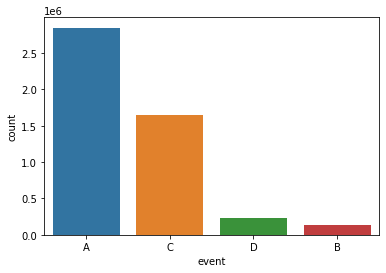

In [ ]:
sns.countplot(train_data["event"])
plt.show()

From the bar plot we can see that event A is occuring more often. That means most of the time the pilot is not distracted. More common distrcation is CA, followed by DA. SS is least occuring distraction

Now, to understand this imbalance more clearly, we can analyse how each of these experiments seperately. For example when the experiment is CA , how often the pilot is enetering into CA state.

This will be understood easily if we sort each experiment in time. We can analyse without sorting also. But it is easier to draw conclusions if sorted

In [16]:
train_time=train_data.sort_values(by="time")#sorting using time
print(train_time.head())

      Unnamed: 0  Unnamed: 0.1.1.1.1.1  crew experiment   time  seat  \
9028       21171                 44623     7         SS  0.003     1   
1347        9656                184915     7         CA  0.003     1   
5860        2079                140121    13         SS  0.003     0   
9550       10266                208138     5         SS  0.003     0   
9832        4724                159217     4         SS  0.004     0   

         eeg_fp1     eeg_f7      eeg_f8     eeg_t4  ...  eeg_pz_gamma  \
9028   14.608400  10.121700   21.863899  -7.276610  ...      0.000710   
1347  105.366997  99.211197  103.542000  60.785702  ...      0.000402   
5860   19.484900 -37.772400    0.196541 -88.781700  ...      0.000546   
9550  -14.613500 -15.663200   -2.075900 -15.044000  ...      0.000395   
9832  -86.741699 -70.389503  -48.672798 -32.938599  ...      0.000427   

      eeg_f3_gamma  eeg_fz_gamma  eeg_f4_gamma  eeg_c4_gamma  eeg_p4_gamma  \
9028      0.001741      0.000607      0.001541    

Now consider each experiment sepratley, and analyse the frequency of occurance of coresponding event

In [4]:
print(np.unique(train_data["crew"])) #we are plotting the above mentioned graph for some randomly selected crews

[ 1  2  3  4  5  6  7  8 13]


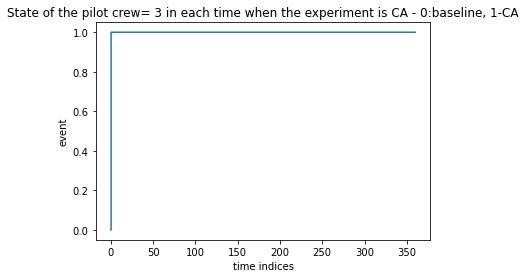

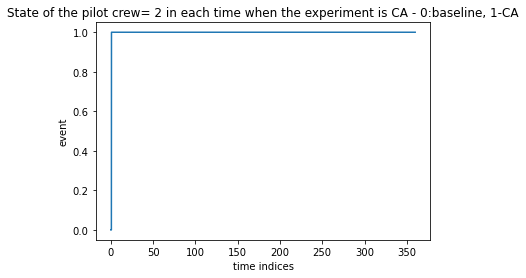

In [65]:
import random
a=random.sample(list(np.unique(train_data["crew"])),2) #randomly selecting two differrent crews
for i in a:
    df=train_time.loc[(train_time["crew"]==i) &(train_time["experiment"]=="CA") ] #we consider the rows with experiment =CA
    evnt=[]
    for event in df["event"]:
        if event=="A":
            evnt.append(0) # if event=baseline we assign a 0 value to it
        else:
            evnt.append(1) #if event is CA we assign 1
    df["extra"]=np.array(evnt)

    plt.plot(df["time"],df["extra"])
    plt.xlabel("time indices")
    plt.ylabel("event")
    plt.title("State of the pilot crew= "+str(i)+" in each time when the experiment is CA - 0:baseline, 1-CA")

    plt.show()



This above figure represents the experiment called CA. The high value or 1 indicate that the state=CA. So when experiment is CA, most of the time pilot will be in CA state. The no event or baseline state is rare. From the bar plot also, the occurance of CA was comaprable to Baseline event


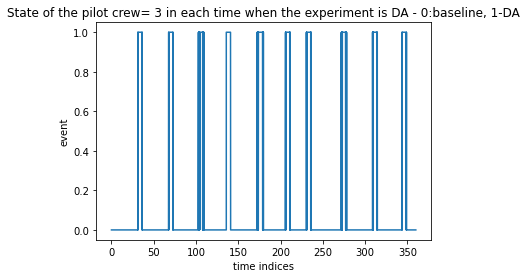

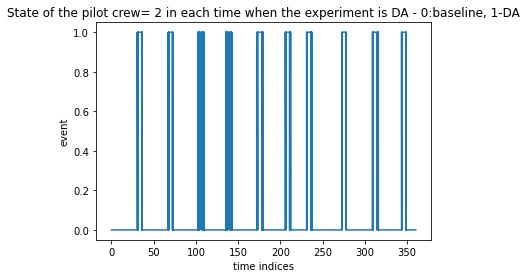

In [66]:
for i in a:
    df=train_time.loc[(train_time["crew"]==i) &(train_time["experiment"]=="DA") ] #we consider the rows with experiment =DA
    evnt=[]
    for event in df["event"]:
        if event=="A":
            evnt.append(0) # if event=baseline we assign a 0 value to it
        else:
            evnt.append(1) #if event is DA we assign 1
    df["extra"]=np.array(evnt)

    plt.plot(df["time"],df["extra"])
    plt.xlabel("time indices")
    plt.ylabel("event")
    plt.title("State of the pilot crew= "+str(i)+" in each time when the experiment is DA - 0:baseline, 1-DA")

    plt.show()



This above figure shows the state of the pilot in each time when the experiment is DA. It is observed that when the pilot is subected to DA experiment, the number of occurances of DA and Baseline are almost same

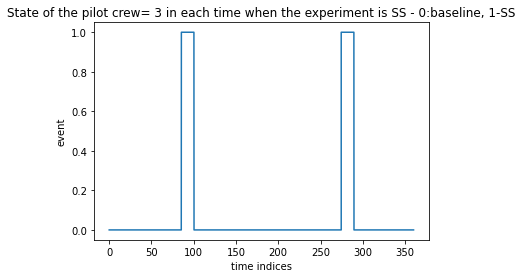

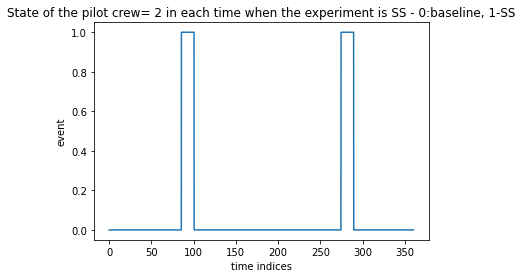

In [67]:
for i in a:
    df=train_time.loc[(train_time["crew"]==i) &(train_time["experiment"]=="SS") ] #we consider the rows with experiment =SS
    evnt=[]
    for event in df["event"]:
        if event=="A":
            evnt.append(0) # if event=baseline we assign a 0 value to it
        else:
            evnt.append(1) #if event is DA we assign 1
    df["extra"]=np.array(evnt)

    plt.plot(df["time"],df["extra"])
    plt.xlabel("time indices")
    plt.ylabel("event")
    plt.title("State of the pilot crew= "+str(i)+" in each time when the experiment is SS - 0:baseline, 1-SS")

    plt.show()



This above graph clearly shows that the event SS is very rare. When the pilot is subjected to the experiment SS, most of the time the pilot is not distraceted. The pilot actually enters into SS event very rarely only


**Conclusions from label analysis:** All the experiments are carried out for same range of time. Still the occurance of some events are rare. Most of the time the pilot is not distracted. But the pilot is likely to enter into CA state are DA state. The posibility of enetering into SS event is rare 

**Analyse attribute - ecg with respect to events**

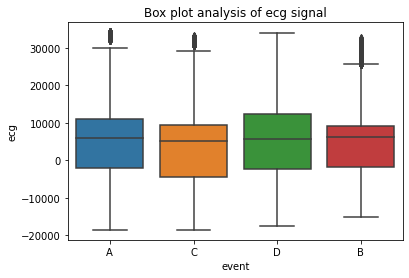

In [ ]:
sns.boxplot(train_data["event"],train_data["ecg"])
plt.title("Box plot analysis of ecg signal")
plt.show()

**Observation:** It is observed that the ecg data has some outliers. But we cannot simply remove them because these extreme values might be useful in predicting the event. 

When the value of ECG is high (more than 10000 microvolts), the pilot is more likely to enter into the DA state. Simlarly, when the value is too negative, the pilot is likely to be in CA state

It is also observed that ecg alone cannot simply predict the events. But it has some role in prediction

**Analyse the presence of noise in ecg data**

We consider 10 seconds of ecg data to analyse the noise present in the data

In [7]:
#this is a code to find out the indices whre time is 10 seconds for CA experiment
ca=train_data[train_data["experiment"]=="CA"]
ca.sort_values(by="time")
ca["time"][:1000]

0       0.011719
1       0.015625
2       0.019531
3       0.023438
4       0.027344
         ...    
995    10.039062
996    10.042969
997    10.042969
998    10.046875
999    10.046875
Name: time, Length: 1000, dtype: float64

No handles with labels found to put in legend.


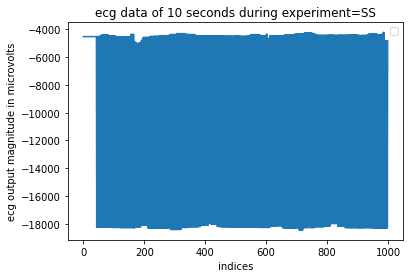

In [ ]:
plt.plot(ca["ecg"][:1000])
plt.title("ecg data of 10 seconds during experiment=SS")
plt.xlabel("indices")
plt.ylabel("ecg output magnitude in microvolts")

plt.show()


We plotted the ecg output for just 10 seconds(1000 data points) for experiment= CA. it is seen that the output is very much rich in noise. This is the same situation when experiment =DA or SS. This is beacause these data are collected from real situations.

This noise should be removed to get some useful insights from the data

**Analyze the attribute - respiration (r)**

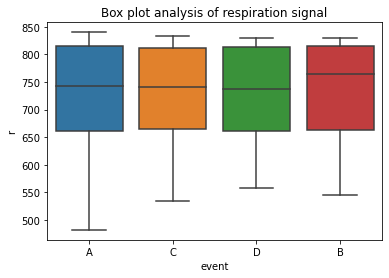

In [ ]:
sns.boxplot(train_data["event"],train_data["r"])
plt.title("Box plot analysis of respiration signal")
plt.show()

**Observation:** Similar to ecg data this data also has some outliers. But we cannot simply remove them because these extreme values might be useful in predicting the event. 

This sensor output is not at all seperating the events. This might be beacuse of the noise in the data.

**Check noise in data**

No handles with labels found to put in legend.


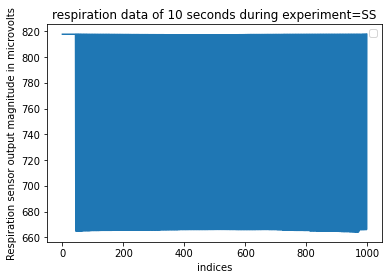

In [ ]:
ca=train_data[train_data["experiment"]=="CA"]
ca.sort_values(by="time")

plt.plot(ca["r"][:1000])
plt.title("respiration data of 10 seconds during experiment=SS")
plt.xlabel("indices")
plt.ylabel("Respiration sensor output magnitude in microvolts")

plt.show()



**Observation:** We have plotted respiration data for 10 seconds for CA experiment. It is seen that the data is full of noise. This should be removed. This is observed when experiment=SS or DA


**Analyse attribute - Galvanic Skin Response**

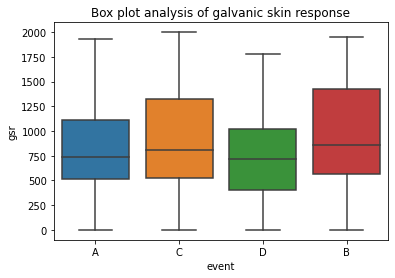

In [ ]:
sns.boxplot(train_data["event"],train_data["gsr"])
plt.title("Box plot analysis of galvanic skin response")
plt.show()



**Observation:** GSR has some role in determining the event. Foe example, if the value from gsr is too high the pilot is more likely to be in SS state. Also if the sensor output is very low, the pilot is probably in CA state

**Check for noise**

No handles with labels found to put in legend.


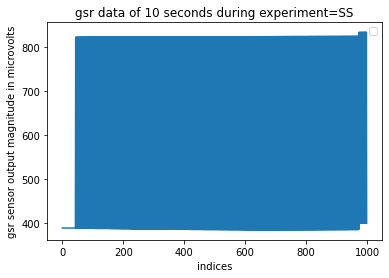

In [ ]:
ca=train_data[train_data["experiment"]=="CA"]
ca.sort_values(by="time")

plt.plot(ca["gsr"][:1000])
plt.title("gsr data of 10 seconds during experiment=SS")
plt.xlabel("indices")
plt.ylabel("gsr sensor output magnitude in microvolts")

plt.show()



This output is also rich in noise. This noise should be removed

**Analuze the attribute- EEG**

In [18]:
eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8','eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3','eeg_pz', 'eeg_f3',
              'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz','eeg_c3', 'eeg_cz', 'eeg_o2']

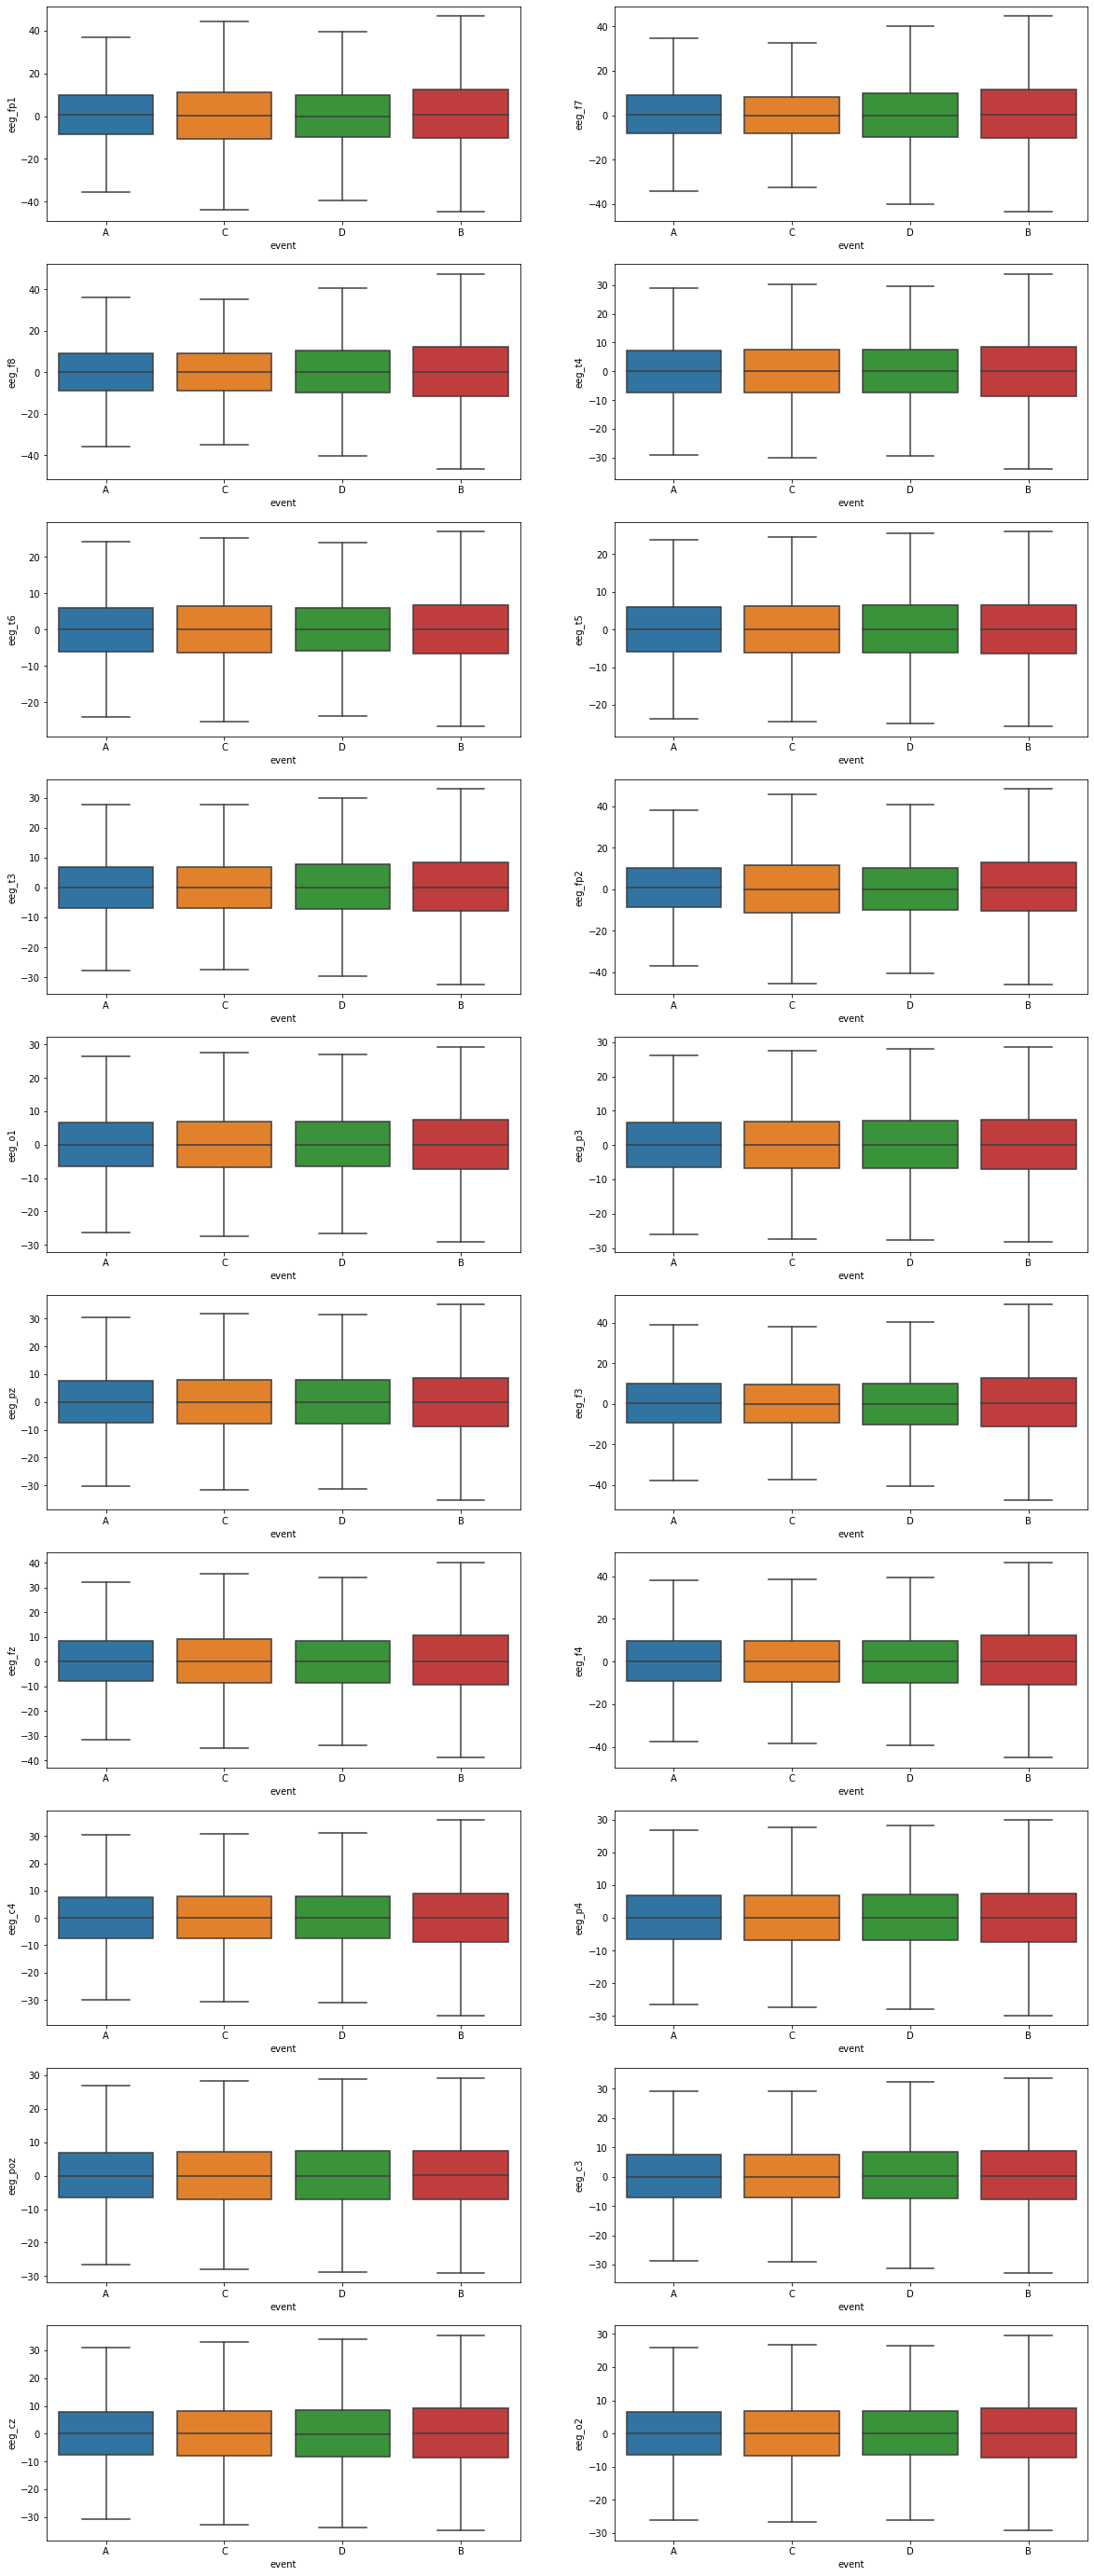

In [9]:
i=0
plt.figure(figsize=(20,50))
for feature in eeg_features:
    plt.subplot(10,2,i+1)
    sns.boxplot(train_data["event"],train_data[feature],showfliers=False)
    i+=1
plt.show()

**Observation:** It is seen that some eeg features has slight direct influence in predicting the events. But most of the features are highly overlapping. So, some more useful features should be derived from eeg features. A more important feature that can be derived from eeg data is the Potential difference between electrodes. It might have more role in predicting the event.

**Removing the noise in the ECG data**

Here we sort the dataframe according to crew and then time. This sorted data frame will be more meaningful when we try to do other operations like filetring

In [69]:
train_data.sort_values(["crew","time"],ascending=True).groupby("experiment")

In [70]:
#https://stackoverflow.com/questions/35588782/how-to-average-a-signal-to-remove-noise-with-python

def remove_noise(data,w):
    n=5 #oder of the filter
    
    b, a = signal.butter(n,w,fs=256) #design a butterworth filter with order N and critical frequnecy w. This will return the filter coefficents
    return signal.filtfilt(b, a, data) 


In [71]:
#https://www.scireslit.com/VascularMedicine/AJVM-ID18.pdf
#http://ems12lead.com/2014/03/10/understanding-ecg-filtering/
w=100 # cutoff frequency- 10*the maximum possible frequency(10Hz or 100 beats per minute)
filtered_ecg_train = remove_noise(train_data["ecg"],w)  #removing noise from train ecg
train_data["filtered_ecg"]=filtered_ecg_train #create a column for filitered ecg in train data


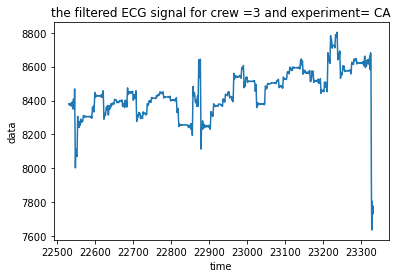

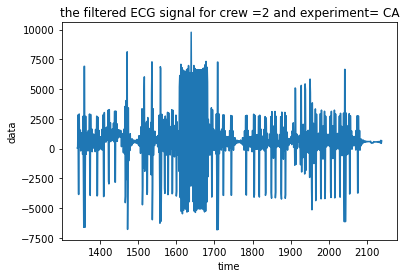

In [72]:

for i in a:
    df=train_data.loc[(train_data["experiment"]=="CA") & (train_data["crew"]==i)]
    df.sort_values(by="time")


    plt.plot(df["filtered_ecg"][200:1000],label="filtered ecg")
    plt.title("the filtered ECG signal for crew ="+str(i)+ " and experiment= CA")
    plt.xlabel("time")
    plt.ylabel("data")

    plt.show()

We can observe the difference between filtered ecg and original ecg from the graph. Some extreme values in the ecg data was due to noise and it is removed during filtering. The extreme fluctautions present in the orginal data is removed through filtering

In [73]:
 #constructing a dataframe to compare the ecg values before and after filtering
comp=pd.DataFrame(columns=["with noise","without noise"])
comp["with noise"]=train_data["ecg"]
comp["without noise"]=filtered_ecg_train
print(comp.head())

   with noise  without noise
0     -4520.0   -4520.262013
1     -4520.0   -4519.703262
2     -4520.0   -4520.180837
3     -4520.0   -4520.093702
4     -4520.0   -4519.550783


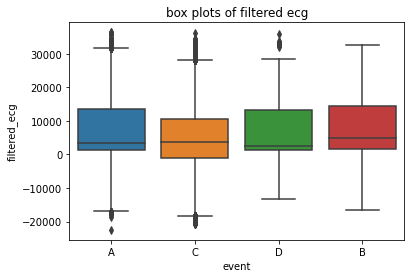

In [74]:
sns.boxplot(train_data["event"],train_data["filtered_ecg"])
plt.title("box plots of filtered ecg")
plt.show()


**Noise removal of Respiration data**

In [75]:
#https://www.intechopen.com/books/advanced-biosignal-processing-and-diagnostic-methods/position-free-vital-sign-monitoring-measurements-and-processing
filtered_r_train=remove_noise(train_data["r"],.7) #removing the noise for train r data
train_data["filtered_r"]=filtered_r_train # add the filterd r data as an attribute to train data


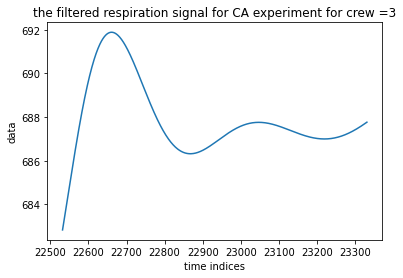

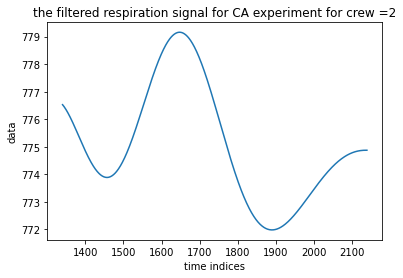

In [76]:
for i in a:
    df=train_data.loc[(train_data["experiment"]=="CA")&(train_data["crew"]==i)]
    df.sort_values(by="time")

# plt.plot(ca["r"][:1000],label="original r data")
    plt.plot(df["filtered_r"][200:1000],label="filtered r data")

    plt.title("the filtered respiration signal for CA experiment for crew ="+str(i)) #ploting the r data before and after filtering
    plt.xlabel("time indices")
    plt.ylabel("data")
# plt.legend()
    plt.show()

here also extreme values are removed from the data by filtering. Some fluctuation is present even after filering. Apart from some fluctuations, the data is more clean after filtering

In [77]:
comp=pd.DataFrame() #construct a dataframe to compare the original and filtered r values
comp["orginal r"]=train_data["r"]
comp["filtered r"]=filtered_r_train
print(comp.head())

    orginal r  filtered r
0  817.705994  797.171693
1  817.705994  796.789539
2  817.705994  796.405522
3  817.705994  796.019679
4  817.705994  795.632050


Text(0.5, 1.0, 'box plot of filtered r data')

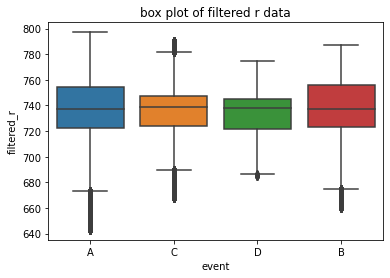

In [78]:
sns.boxplot(train_data["event"],train_data["filtered_r"])
plt.title("box plot of filtered r data")

The above plot is shows that the filtered respiration data is much more useful in predicting the events.  As we can see, during the event SS the valule from the sensor is typically higher which is true in reality also

**Deriving the heart beat information from ECG**

In [5]:
train_data.columns

Index(['Unnamed: 0', 'crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7',
       'eeg_f8', 'eeg_t4', 'eeg_t6',
       ...
       'eeg_pz_gamma', 'eeg_f3_gamma', 'eeg_fz_gamma', 'eeg_f4_gamma',
       'eeg_c4_gamma', 'eeg_p4_gamma', 'eeg_poz_gamma', 'eeg_c3_gamma',
       'eeg_cz_gamma', 'eeg_o2_gamma'],
      dtype='object', length=131)

In [79]:
#ecg.ecg is the function inside the biosppy module to get more useful information from the ecg data
#for each experiment, we extract the ecg data seperately
ecg_bio_ca=ecg.ecg(train_data[train_data["experiment"]=="CA"]["filtered_ecg"],sampling_rate=256,show=False) #give the filtered ecg into the biosppy module and check what all this will return
print(ecg_bio_ca.keys()) #this gives the features provided by the above function

ecg_bio_da=ecg.ecg(train_data[train_data["experiment"]=="DA"]["filtered_ecg"],sampling_rate=256,show=False)

ecg_bio_ss=ecg.ecg(train_data[train_data["experiment"]=="SS"]["filtered_ecg"],sampling_rate=256,show=False)

['ts', 'filtered', 'rpeaks', 'templates_ts', 'templates', 'heart_rate_ts', 'heart_rate']


From the biosppy module, we can get some useful features. Of these,the heart rate and location of r peaks can be useful in preidicting the state or event for a pilot

In [142]:
print(ecg_bio_ca["heart_rate_ts"].shape)

(5486,)


The output heart rate from the biosppy module is of at some particular timesteps. The heart rate corresponding to all the time stamps in our data set is not availbale. So we need to find out these values. Interpoltaion is used for this purpose

In [80]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
def interpolation_fn(timestamps,biosppy_ts, biosppy_values):

    interpolation = interp1d(biosppy_ts,biosppy_values, kind="linear", fill_value="extrapolate") #Kind can be linear, quadratic or cubic. fill value is NAN if not given
    return interpolation(timestamps) #this is the time stamps where we need to get the interpolated values That is the time stamps in the dataframe



In [81]:
#interpolate the heart rate for all three experiments and combine all
heart_rate_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],ecg_bio_ca["heart_rate_ts"],ecg_bio_ca["heart_rate"])
heart_rate_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],ecg_bio_da["heart_rate_ts"],ecg_bio_da["heart_rate"])
heart_rate_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],ecg_bio_ss["heart_rate_ts"],ecg_bio_ss["heart_rate"])

heart_rate=np.concatenate((heart_rate_ca,heart_rate_da,heart_rate_ss))
print(heart_rate.shape)
train_data["heart_rate"]=heart_rate 

(4867421,)


**Plotting the heart rate from biosppy after interpolation**

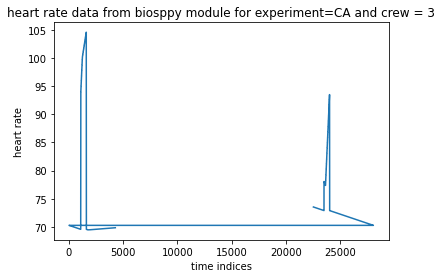

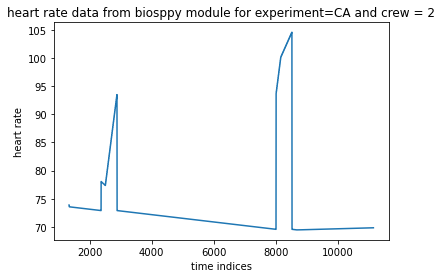

In [82]:
for i in a:
    df=train_data.loc[(train_data["experiment"]=="CA")&(train_data["crew"]==i)]
    plt.plot(df["heart_rate"][200:10000])
    plt.title("heart rate data from biosppy module for experiment=CA and crew = "+str(i))
    plt.xlabel("time indices")
    plt.ylabel("heart rate")
    plt.show()


**Check if the heart rate has any role in predicting the event**

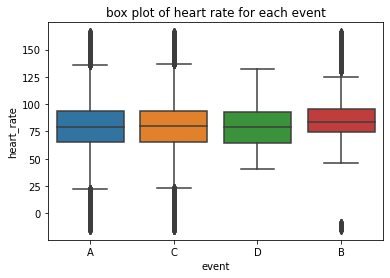

In [64]:
sns.boxplot(train_data["event"],train_data["heart_rate"])
plt.title("box plot of heart rate for each event")
plt.show()

It is clear that heart rate plays a more important role in predicting the event when compared to the ecg output only. From the figure, when the heart rate is very high, the pilot is more likely to be in startle stage. This feature will be very useful



The heart rate derived from th original noisy data is much worse than the heart rate obtained from the filtered data. So we proeed to go with the heart beat obtained from the filtered data itself

**Deriving the respiration rate from respiration sensor using Biosppy module**

In [83]:
#resp.resp is the function inside the biosppy module to get more useful information from the respiration sensor

r_bio_ca=resp.resp(train_data[train_data["experiment"]=="CA"]["filtered_r"],sampling_rate=256,show=False) #give the filtered r data into the biosppy module and check what all this will return
print(r_bio_ca.keys()) #this gives the features provided by the above function
r_bio_da=resp.resp(train_data[train_data["experiment"]=="DA"]["filtered_r"],sampling_rate=256,show=False)

r_bio_ss=resp.resp(train_data[train_data["experiment"]=="SS"]["filtered_r"],sampling_rate=256,show=False)

['ts', 'filtered', 'zeros', 'resp_rate_ts', 'resp_rate']


In [181]:
print(r_bio_ca["ts"].shape)

(1658376,)


Here also we need to do the interpolation to get the data in all other time stamps

In [84]:
#we need to interpolate respiration rate also
resp_rate_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],r_bio_ca["resp_rate_ts"],r_bio_ca["resp_rate"])
resp_rate_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],r_bio_da["resp_rate_ts"],r_bio_da["resp_rate"])
resp_rate_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],r_bio_ss["resp_rate_ts"],r_bio_ss["resp_rate"])

resp_rate=np.concatenate((resp_rate_ca,resp_rate_da,resp_rate_ss))
print(resp_rate.shape)
train_data["resp_rate"]=resp_rate

(4867421,)


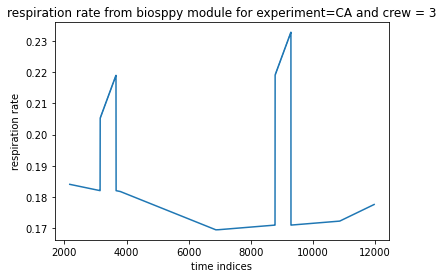

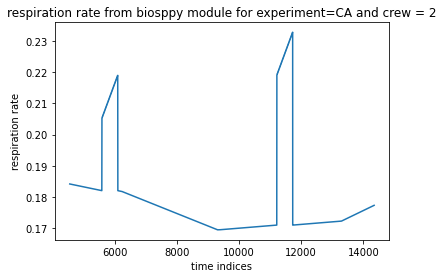

In [183]:
for i in a:
    df=train_data.loc[(train_data["experiment"]=="CA")&(train_data["crew"]==i)]
    plt.plot(df["resp_rate"][200:10000])
    plt.title("respiration rate from biosppy module for experiment=CA and crew = "+str(i))
    plt.xlabel("time indices")
    plt.ylabel("respiration rate")
    plt.show()


**Analyse the effect of respiration rate in predicting the events**

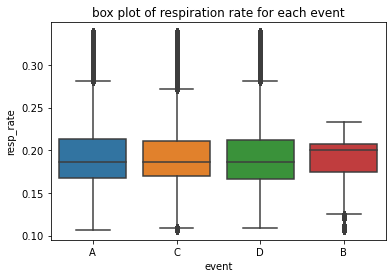

In [184]:
#https://ict.usc.edu/pubs/Real-time%20expression%20of%20affect%20through%20respiration.pdf
sns.boxplot(train_data["event"],train_data["resp_rate"])
plt.title("box plot of respiration rate for each event")
plt.show()

**Deriving potential differnce from electrodes**

In [ ]:
from google.colab import files
files=files.upload()

Saving montages.PNG to montages.PNG


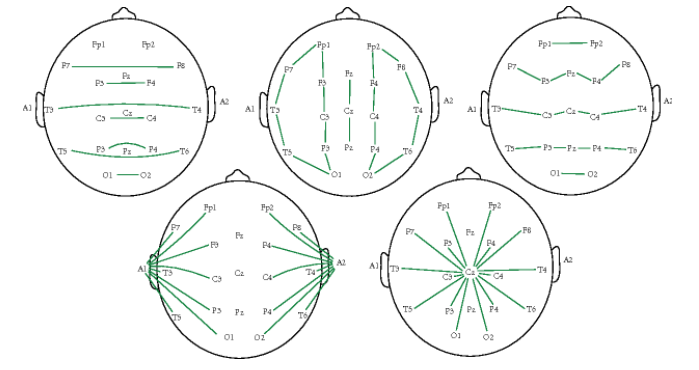

In [ ]:

from IPython.display import Image
Image("montages.PNG", width=700, height=300)

Above figure shows, the different combination of 20 electrodes to calculate the potential difference. For now, we just calculate the potential difference based on the second arrangement. This is because the potential difference from this combination is most commonl used in clinic. However during modeling, we need to chek if some other combination is providing a better result or not

In [85]:
train_data["fp1_f7"]=train_data["eeg_fp1"]-train_data["eeg_f7"]
train_data["f7_t3"]=train_data["eeg_f7"]-train_data["eeg_t3"]
train_data["t3_t5"]=train_data["eeg_t3"]-train_data["eeg_t5"]
train_data["t5_o1"]=train_data["eeg_t5"]-train_data["eeg_o1"]
train_data["p3_o1"]=train_data["eeg_p3"]-train_data["eeg_o1"]
train_data["c3_p3"]=train_data["eeg_c3"]-train_data["eeg_p3"]
train_data["f3_c3"]=train_data["eeg_f3"]-train_data["eeg_c3"]
train_data["fp1_f3"]=train_data["eeg_fp1"]-train_data["eeg_f3"]

train_data["fzcz"]=train_data["eeg_fz"]-train_data["eeg_cz"]
train_data["czpz"]=train_data["eeg_cz"]-train_data["eeg_pz"]

train_data["fp2_f4"]=train_data["eeg_fp2"]-train_data["eeg_f4"]
train_data["f4_c4"]=train_data["eeg_f4"]-train_data["eeg_c4"]
train_data["c4_p4"]=train_data["eeg_c4"]-train_data["eeg_p4"]
train_data["p4_o2"]=train_data["eeg_p4"]-train_data["eeg_o2"]
train_data["t6_o2"]=train_data["eeg_t6"]-train_data["eeg_o2"]
train_data["t4_t6"]=train_data["eeg_t4"]-train_data["eeg_t6"]
train_data["f8_t4"]=train_data["eeg_f8"]-train_data["eeg_t4"]
train_data["fp2_f8"]=train_data["eeg_fp2"]-train_data["eeg_f8"]

**Deriving Frequency Bands from EEG data**

For getting the frequency bands corresponding to eeg signal we use biosppy module. This will return the frequnecy bands for each of 20 electrode signals. So, we pass the whole eeg data or eeg matrix as the input to the biosppy and derive all the frequency bands- aplha, beta, delta and gamma from it

In [86]:
eeg_bio_ca=eeg.get_power_features(train_data[train_data["experiment"]=="CA"][eeg_features],sampling_rate=256)
eeg_bio_da=eeg.get_power_features(train_data[train_data["experiment"]=="DA"][eeg_features],sampling_rate=256)
eeg_bio_ss=eeg.get_power_features(train_data[train_data["experiment"]=="SS"][eeg_features],sampling_rate=256)
print(eeg_bio_ca.keys())
#here we give a matrix of all the EEG signals as input and this function returns the various frequency bands

['ts', 'theta', 'alpha_low', 'alpha_high', 'beta', 'gamma']


The ouputs from the biosppy module contains 5 frequency bands(The notations are slighltly diiferent):
Theta: 4 to 8 Hz, 
Lower Alpha: 8 to 10 Hz,
Higher Alpha: 10 to 13 Hz,
Beta: 13 to 25 Hz,
Gamma: 25 to 40 Hz

We need to derive these frequency band information for each of the eeg electrodes

In [88]:
theta_feature=[i+"_theta" for i in eeg_features]
import tqdm 
from tqdm import tqdm
# we take the beta frequency band and do the interpolation and store the data in the dataframe
for i in tqdm(range(20)):
    theta_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],eeg_bio_ca["ts"],eeg_bio_ca["theta"][:,i])
    theta_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],eeg_bio_da["ts"],eeg_bio_da["theta"][:,i])
    theta_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],eeg_bio_ss["ts"],eeg_bio_ss["theta"][:,i])

    theta=np.concatenate((theta_ca,theta_da,theta_ss))

    train_data[theta_feature[i]]=theta

100%|██████████| 20/20 [02:44<00:00,  8.21s/it]


In [19]:
alpha_low_feature=[i+"_alpha_low" for i in eeg_features]


In [90]:
# we take the alpha_low frequency band and do the interpolation and store the data in the dataframe
for i in range(20):
    alpha_low_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],eeg_bio_ca["ts"],eeg_bio_ca["alpha_low"][:,i])
    alpha_low_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],eeg_bio_da["ts"],eeg_bio_da["alpha_low"][:,i])
    alpha_low_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],eeg_bio_ss["ts"],eeg_bio_ss["alpha_low"][:,i])

    alpha_low=np.concatenate((alpha_low_ca,alpha_low_da,alpha_low_ss))

    train_data[alpha_low_feature[i]]=alpha_low

In [10]:

alpha_high_feature=[i+"_alpha_high" for i in eeg_features]

In [92]:
# we take the alpha_high frequency band and do the interpolation and store the data in the dataframe
for i in tqdm(range(20)):
    alpha_high_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],eeg_bio_ca["ts"],eeg_bio_ca["alpha_high"][:,i])
    alpha_high_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],eeg_bio_da["ts"],eeg_bio_da["alpha_high"][:,i])
    alpha_high_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],eeg_bio_ss["ts"],eeg_bio_ss["alpha_high"][:,i])

    alpha_high=np.concatenate((alpha_high_ca,alpha_high_da,alpha_high_ss))

    train_data[alpha_high_feature[i]]=alpha_high

100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


In [93]:
beta_feature=[i+"_beta" for i in eeg_features]
import tqdm 
from tqdm import tqdm
# we take the beta frequency band and do the interpolation and store the data in the dataframe
for i in tqdm(range(20)):
    beta_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],eeg_bio_ca["ts"],eeg_bio_ca["beta"][:,i])
    beta_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],eeg_bio_da["ts"],eeg_bio_da["beta"][:,i])
    beta_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],eeg_bio_ss["ts"],eeg_bio_ss["beta"][:,i])

    beta=np.concatenate((beta_ca,beta_da,beta_ss))

    train_data[beta_feature[i]]=beta

100%|██████████| 20/20 [01:16<00:00,  3.84s/it]


In [94]:

gamma_feature=[i+"_gamma" for i in eeg_features]
# we take the gamma frequency band and do the interpolation and store the data in the dataframe
for i in tqdm (range(20)):
    gamma_ca=interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"],eeg_bio_ca["ts"],eeg_bio_ca["gamma"][:,i])
    gamma_da=interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"],eeg_bio_da["ts"],eeg_bio_da["gamma"][:,i])
    gamma_ss=interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"],eeg_bio_ss["ts"],eeg_bio_ss["gamma"][:,i])

    gamma=np.concatenate((gamma_ca,gamma_da,gamma_ss))

    train_data[gamma_feature[i]]=gamma
    

100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


**Summary:**

So far, we have obtained the filtered data from ecg and respiration sensors

We derived information like heart beat(from ecg), respiration data(from r sensor)

We derived potential difference from eeg sensors

We derived frequency band information from the eeg signals


Now we need to check if we can remove the unneceassary index column, replace the original sensor data with filtered sensor data and store it as another csv file. 

**Analyse the correlation of different features using corr() function and using phi_k**

We replace the "event" column using the corresponding label encoded represenation

In [6]:
d={"A":0,"B":1,"C":2,"D":3}
e=train_data["event"]
e=list(map(lambda i:d[i],e))
train_data["e"]=e

In [13]:
#correlation of filetered signals, heart beat and respiration rate with respect to event
g=["e","crew","seat","r","filtered_r","ecg","filtered_ecg","heart_rate","resp_rate"]
train_data[g].corr()


,e,crew,seat,r,filtered_r,ecg,filtered_ecg,heart_rate,resp_rate
e,1.000000,-0.013677,-0.000034,-0.003308,-0.009118,-0.051368,-0.060653,0.009073,-0.002225
crew,-0.013677,1.000000,-0.000026,0.017672,0.055986,-0.092310,-0.108643,-0.011466,-0.047382
seat,-0.000034,-0.000026,1.000000,0.895856,0.006655,0.065637,0.048108,0.000092,0.000065
r,-0.003308,0.017672,0.895856,1.000000,0.316567,0.049906,0.031924,0.032070,0.014580
filtered_r,-0.009118,0.055986,0.006655,0.316567,1.000000,-0.023738,-0.027938,0.101556,0.046227
ecg,-0.051368,-0.092310,0.065637,0.049906,-0.023738,1.000000,0.852744,-0.062728,-0.040190
filtered_ecg,-0.060653,-0.108643,0.048108,0.031924,-0.027938,0.852744,1.000000,-0.073832,-0.047305
heart_rate,0.009073,-0.011466,0.000092,0.032070,0.101556,-0.062728,-0.073832,1.000000,0.285386
resp_rate,-0.002225,-0.047382,0.000065,0.014580,0.046227,-0.040190,-0.047305,0.285386,1.000000


In [16]:
print("correlation using phi_k")
train_data[g].phik_matrix()

interval columns not set, guessing: ['e', 'crew', 'seat', 'r', 'filtered_r', 'ecg', 'filtered_ecg', 'heart_rate', 'resp_rate']


,e,crew,seat,r,filtered_r,ecg,filtered_ecg,heart_rate,resp_rate
e,1.000000,0.025744,0.000000,0.175088,0.165173,0.192374,0.225958,0.081059,0.159596
crew,0.025744,1.000000,0.000000,0.744488,0.783688,0.816010,0.837668,0.266777,0.314389
seat,0.000000,0.000000,1.000000,0.999939,0.023375,0.855309,0.269761,0.000000,0.000000
r,0.175088,0.744488,0.999939,1.000000,0.865523,0.878833,0.716194,0.209706,0.226054
filtered_r,0.165173,0.783688,0.023375,0.865523,1.000000,0.725319,0.711128,0.256850,0.262586
ecg,0.192374,0.816010,0.855309,0.878833,0.725319,1.000000,0.889802,0.213177,0.252415
filtered_ecg,0.225958,0.837668,0.269761,0.716194,0.711128,0.889802,1.000000,0.265573,0.260836
heart_rate,0.081059,0.266777,0.000000,0.209706,0.256850,0.213177,0.265573,1.000000,0.547894
resp_rate,0.159596,0.314389,0.000000,0.226054,0.262586,0.252415,0.260836,0.547894,1.000000


From the above correlation plot we can observe that, the effect of crew in determing the event is very high. 

Also, seat has very low correlation with event, so we can ignore that column

The effect of filtered ecg in predicting the event is higher than the effect of unfiltered ecg. For respiration data also, filtered data is having more correlation with event. So we can replace ecg and r with corresponding filtered signals

The derived features like heart beat and respiration rate is also having some correlation with event

In [17]:
#correlation of eeg signals and potential difference of elctrodes with respect to event
g=["e"]
g.extend(eeg_features)
g.extend(["fp1_f7","f7_t3","t3_t5","t5_o1","p3_o1","c3_p3","f3_c3","fp1_f3","fzcz",
"czpz","fp2_f4","f4_c4","c4_p4","p4_o2","t6_o2","t4_t6","f8_t4","fp2_f8"])

train_data[g].corr()

,e,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,...,fzcz,czpz,fp2_f4,f4_c4,c4_p4,p4_o2,t6_o2,t4_t6,f8_t4,fp2_f8
e,1.000000,-0.018637,-0.005745,-0.005377,0.000721,-0.000426,0.000790,0.001524,-0.016133,0.000552,...,-0.004606,-0.001366,-0.010282,-0.002993,-0.009157,0.001010,0.001071,0.001195,-0.007492,-0.017992
eeg_fp1,-0.018637,1.000000,0.649661,0.561712,0.434736,0.328606,0.332473,0.412335,0.808817,0.230432,...,0.239841,0.010353,0.456736,0.126063,0.233332,0.006739,-0.046448,0.219985,0.333259,0.568954
eeg_f7,-0.005745,0.649661,1.000000,0.493707,0.454118,0.309661,0.466838,0.510271,0.666813,0.158739,...,0.147599,0.071693,0.429563,0.038284,0.135325,0.028873,-0.010776,0.258509,0.229466,0.434163
eeg_f8,-0.005377,0.561712,0.493707,1.000000,0.624069,0.428697,0.367796,0.361123,0.743647,0.201592,...,0.222028,0.063498,0.422059,0.057475,0.294497,0.065091,0.054573,0.352563,0.725337,-0.028120
eeg_t4,0.000721,0.434736,0.454118,0.624069,1.000000,0.537165,0.398861,0.509766,0.520755,0.271376,...,0.211830,0.011433,0.228751,0.090384,0.084652,0.007047,0.072487,0.692963,-0.085230,0.067178
eeg_t6,-0.000426,0.328606,0.309661,0.428697,0.537165,1.000000,0.496123,0.387109,0.370542,0.341525,...,0.066483,-0.015075,0.101095,0.005026,0.056896,0.024574,0.328395,-0.235888,0.073404,0.065308
eeg_t5,0.000790,0.332473,0.466838,0.367796,0.398861,0.496123,1.000000,0.528224,0.355093,0.356271,...,0.081885,0.071967,0.166531,-0.057288,0.083599,-0.040627,-0.050045,0.035466,0.117593,0.111635
eeg_t3,0.001524,0.412335,0.510271,0.361123,0.509766,0.387109,0.528224,1.000000,0.367574,0.270236,...,0.126183,0.024082,0.174775,0.004102,0.061917,0.003395,-0.015443,0.256422,0.011376,0.137903
eeg_fp2,-0.016133,0.808817,0.666813,0.743647,0.520755,0.370542,0.355093,0.367574,1.000000,0.189598,...,0.222368,0.052575,0.618618,0.115691,0.292355,0.034425,-0.010811,0.283242,0.489470,0.647397
eeg_o1,0.000552,0.230432,0.158739,0.201592,0.271376,0.341525,0.356271,0.270236,0.189598,1.000000,...,0.016638,-0.204951,0.047391,-0.027786,-0.068439,-0.291604,-0.334342,0.020732,0.017975,0.053666


In [23]:
g=["e","fp1_f7","f7_t3","t3_t5","t5_o1","p3_o1","c3_p3","f3_c3","fp1_f3","fzcz",
"czpz","fp2_f4","f4_c4","c4_p4","p4_o2","t6_o2","t4_t6","f8_t4","fp2_f8"]
print("correlation using phi_k")
train_data[g].phik_matrix()

correlation using phi_k
interval columns not set, guessing: ['e', 'fp1_f7', 'f7_t3', 't3_t5', 't5_o1', 'p3_o1', 'c3_p3', 'f3_c3', 'fp1_f3', 'fzcz', 'czpz', 'fp2_f4', 'f4_c4', 'c4_p4', 'p4_o2', 't6_o2', 't4_t6', 'f8_t4', 'fp2_f8']


,e,fp1_f7,f7_t3,t3_t5,t5_o1,p3_o1,c3_p3,f3_c3,fp1_f3,fzcz,czpz,fp2_f4,f4_c4,c4_p4,p4_o2,t6_o2,t4_t6,f8_t4,fp2_f8
e,1.000000,0.041422,0.046493,0.026706,0.032445,0.033937,0.058341,0.063387,0.058678,0.033725,0.053253,0.032261,0.029970,0.040583,0.032055,0.044808,0.019885,0.029019,0.039887
fp1_f7,0.041422,1.000000,0.798296,0.369677,0.522706,0.483318,0.322628,0.189319,0.797860,0.410669,0.249515,0.557702,0.263290,0.367088,0.373903,0.486202,0.487467,0.565050,0.657596
f7_t3,0.046493,0.798296,1.000000,0.798543,0.593432,0.545875,0.334296,0.309377,0.452930,0.296172,0.209609,0.631568,0.262054,0.366764,0.365753,0.416362,0.713562,0.616546,0.683904
t3_t5,0.026706,0.369677,0.798543,1.000000,0.300732,0.234987,0.207780,0.202800,0.264043,0.219852,0.241787,0.737801,0.599149,0.438225,0.244571,0.289058,0.464915,0.695448,0.340343
t5_o1,0.032445,0.522706,0.593432,0.300732,1.000000,0.974937,0.293564,0.222553,0.403617,0.131676,0.439815,0.542896,0.302791,0.488259,0.590539,0.622442,0.148581,0.396357,0.405327
p3_o1,0.033937,0.483318,0.545875,0.234987,0.974937,1.000000,0.322481,0.226634,0.358308,0.086531,0.389913,0.440315,0.269624,0.444008,0.581170,0.608039,0.114664,0.334658,0.299201
c3_p3,0.058341,0.322628,0.334296,0.207780,0.293564,0.322481,1.000000,0.206012,0.243070,0.198867,0.117659,0.293076,0.102391,0.394058,0.371087,0.404915,0.363327,0.198802,0.422096
f3_c3,0.063387,0.189319,0.309377,0.202800,0.222553,0.226634,0.206012,1.000000,0.902198,0.101879,0.178068,0.528287,0.648614,0.156466,0.176428,0.177682,0.270017,0.246861,0.193772
fp1_f3,0.058678,0.797860,0.452930,0.264043,0.403617,0.358308,0.243070,0.902198,1.000000,0.306215,0.192635,0.581771,0.501252,0.266410,0.267604,0.330986,0.225114,0.422269,0.442857
fzcz,0.033725,0.410669,0.296172,0.219852,0.131676,0.086531,0.198867,0.101879,0.306215,1.000000,0.049636,0.266703,0.058599,0.077595,0.070423,0.140260,0.530364,0.294012,0.263323


It is observed from the above output that some potential differences are having more impact in predicting th events as compared to the eeg electrode data

In [20]:
#correlation between the theta feature and event
theta_feature=[i+"_theta" for i in eeg_features]
g=["e"]
g.extend(theta_feature)
train_data[g].corr()

,e,eeg_fp1_theta,eeg_f7_theta,eeg_f8_theta,eeg_t4_theta,eeg_t6_theta,eeg_t5_theta,eeg_t3_theta,eeg_fp2_theta,eeg_o1_theta,...,eeg_pz_theta,eeg_f3_theta,eeg_fz_theta,eeg_f4_theta,eeg_c4_theta,eeg_p4_theta,eeg_poz_theta,eeg_c3_theta,eeg_cz_theta,eeg_o2_theta
e,1.000000,-0.015906,-0.016243,-0.017989,-0.017477,-0.017495,-0.019968,-0.017832,-0.017133,-0.016306,...,-0.010520,-0.016555,-0.021953,-0.017584,-0.016833,-0.016754,-0.016649,-0.017090,-0.022415,-0.011300
eeg_fp1_theta,-0.015906,1.000000,0.978809,0.951739,0.946216,0.957623,0.881119,0.950430,0.984786,0.964369,...,0.196622,0.980978,0.367054,0.963531,0.971050,0.967328,0.968516,0.969389,0.341873,0.182145
eeg_f7_theta,-0.016243,0.978809,1.000000,0.936553,0.955280,0.967297,0.896253,0.966020,0.956895,0.973400,...,0.183573,0.987675,0.339949,0.961439,0.974894,0.976739,0.978029,0.979674,0.318915,0.183405
eeg_f8_theta,-0.017989,0.951739,0.936553,1.000000,0.964141,0.971749,0.943877,0.970197,0.980087,0.952585,...,0.232198,0.965446,0.411448,0.986266,0.981279,0.973971,0.968828,0.970608,0.333605,0.255735
eeg_t4_theta,-0.017477,0.946216,0.955280,0.964141,1.000000,0.967305,0.936038,0.984338,0.960629,0.950798,...,0.189679,0.976192,0.327758,0.991521,0.977274,0.975751,0.968769,0.975666,0.290077,0.229870
eeg_t6_theta,-0.017495,0.957623,0.967297,0.971749,0.967305,1.000000,0.943300,0.983822,0.964587,0.980770,...,0.216267,0.986085,0.384636,0.979688,0.992053,0.992842,0.991646,0.990666,0.329996,0.211890
eeg_t5_theta,-0.019968,0.881119,0.896253,0.943877,0.936038,0.943300,1.000000,0.967331,0.908817,0.914001,...,0.218463,0.930501,0.384439,0.949772,0.945936,0.946626,0.939372,0.947362,0.287247,0.422712
eeg_t3_theta,-0.017832,0.950430,0.966020,0.970197,0.984338,0.983822,0.967331,1.000000,0.960068,0.967365,...,0.201191,0.986352,0.354590,0.990048,0.989284,0.990200,0.985203,0.991769,0.291802,0.266310
eeg_fp2_theta,-0.017133,0.984786,0.956895,0.980087,0.960629,0.964587,0.908817,0.960068,1.000000,0.958526,...,0.216861,0.975839,0.385545,0.980614,0.977895,0.971339,0.969184,0.970698,0.336927,0.204112
eeg_o1_theta,-0.016306,0.964369,0.973400,0.952585,0.950798,0.980770,0.914001,0.967365,0.958526,1.000000,...,0.217401,0.984592,0.393714,0.963120,0.985887,0.988240,0.993335,0.988314,0.358742,0.202049


In [21]:
train_data[g[:17]].phik_matrix()

interval columns not set, guessing: ['e', 'eeg_fp1_theta', 'eeg_f7_theta', 'eeg_f8_theta', 'eeg_t4_theta', 'eeg_t6_theta', 'eeg_t5_theta', 'eeg_t3_theta', 'eeg_fp2_theta', 'eeg_o1_theta', 'eeg_p3_theta', 'eeg_pz_theta', 'eeg_f3_theta', 'eeg_fz_theta', 'eeg_f4_theta', 'eeg_c4_theta', 'eeg_p4_theta']


,e,eeg_fp1_theta,eeg_f7_theta,eeg_f8_theta,eeg_t4_theta,eeg_t6_theta,eeg_t5_theta,eeg_t3_theta,eeg_fp2_theta,eeg_o1_theta,eeg_p3_theta,eeg_pz_theta,eeg_f3_theta,eeg_fz_theta,eeg_f4_theta,eeg_c4_theta,eeg_p4_theta
e,1.000000,0.016602,0.017220,0.051050,0.021453,0.019498,0.022902,0.021085,0.045358,0.019141,0.019096,0.037990,0.018118,0.038008,0.018978,0.019159,0.019331
eeg_fp1_theta,0.016602,1.000000,0.980347,0.975453,0.966686,0.975712,0.960932,0.976075,0.990788,0.975415,0.977167,0.449119,0.982912,0.626616,0.986313,0.982058,0.974762
eeg_f7_theta,0.017220,0.980347,1.000000,0.959389,0.965904,0.989494,0.984037,0.982011,0.975246,0.974737,0.992319,0.445435,0.997893,0.619969,0.976917,0.988109,0.993850
eeg_f8_theta,0.051050,0.975453,0.959389,1.000000,0.966963,0.962948,0.955613,0.966776,0.987561,0.956949,0.959908,0.494736,0.967267,0.659182,0.980699,0.966202,0.961381
eeg_t4_theta,0.021453,0.966686,0.965904,0.966963,1.000000,0.966707,0.972483,0.980556,0.974373,0.965440,0.967419,0.477753,0.969765,0.583122,0.985493,0.965593,0.965768
eeg_t6_theta,0.019498,0.975712,0.989494,0.962948,0.966707,1.000000,0.977133,0.987229,0.973263,0.982959,0.994263,0.549076,0.991193,0.641215,0.973873,0.995216,0.997346
eeg_t5_theta,0.022902,0.960932,0.984037,0.955613,0.972483,0.977133,1.000000,0.985089,0.961843,0.954902,0.976107,0.483000,0.984151,0.601184,0.967277,0.973658,0.976673
eeg_t3_theta,0.021085,0.976075,0.982011,0.966776,0.980556,0.987229,0.985089,1.000000,0.976104,0.967507,0.977676,0.552364,0.982902,0.616317,0.984115,0.982931,0.983115
eeg_fp2_theta,0.045358,0.990788,0.975246,0.987561,0.974373,0.973263,0.961843,0.976104,1.000000,0.969790,0.973719,0.486332,0.980668,0.652699,0.987216,0.983367,0.974843
eeg_o1_theta,0.019141,0.975415,0.974737,0.956949,0.965440,0.982959,0.954902,0.967507,0.969790,1.000000,0.987140,0.513183,0.979229,0.645478,0.966170,0.981051,0.981814


Theta feature is having some considerable effect in events. The correlation is considerabel. So this feature will be useful in predicting the event

In [27]:
#correlation between alpha low frequency abnd features and event
g=["e"]
g.extend(alpha_low_feature)
train_data[g].corr()

,e,eeg_fp1_alpha_low,eeg_f7_alpha_low,eeg_f8_alpha_low,eeg_t4_alpha_low,eeg_t6_alpha_low,eeg_t5_alpha_low,eeg_t3_alpha_low,eeg_fp2_alpha_low,eeg_o1_alpha_low,...,eeg_pz_alpha_low,eeg_f3_alpha_low,eeg_fz_alpha_low,eeg_f4_alpha_low,eeg_c4_alpha_low,eeg_p4_alpha_low,eeg_poz_alpha_low,eeg_c3_alpha_low,eeg_cz_alpha_low,eeg_o2_alpha_low
e,1.000000,-0.018524,-0.017802,-0.021522,-0.018996,-0.020430,-0.020151,-0.017320,-0.016788,-0.014296,...,-0.004906,-0.016190,-0.022408,-0.018538,-0.018084,-0.019533,-0.015879,-0.018446,-0.014437,-0.013909
eeg_fp1_alpha_low,-0.018524,1.000000,0.771483,0.776984,0.669622,0.685589,0.676602,0.696074,0.902015,0.706123,...,0.165838,0.782604,0.317371,0.793727,0.715071,0.701665,0.704220,0.738921,0.180084,0.217450
eeg_f7_alpha_low,-0.017802,0.771483,1.000000,0.767156,0.727534,0.762320,0.780669,0.824048,0.718910,0.808635,...,0.190041,0.892374,0.309855,0.800316,0.784894,0.789299,0.798707,0.865974,0.201806,0.249156
eeg_f8_alpha_low,-0.021522,0.776984,0.767156,1.000000,0.773205,0.773558,0.711848,0.695412,0.819736,0.743774,...,0.183674,0.789077,0.284239,0.867621,0.801821,0.780317,0.751895,0.768997,0.184736,0.253332
eeg_t4_alpha_low,-0.018996,0.669622,0.727534,0.773205,1.000000,0.783415,0.731118,0.709082,0.661360,0.743043,...,0.150964,0.744871,0.240722,0.796555,0.790192,0.785140,0.749473,0.742053,0.178516,0.252550
eeg_t6_alpha_low,-0.020430,0.685589,0.762320,0.773558,0.783415,1.000000,0.765104,0.751928,0.673122,0.808191,...,0.166881,0.778340,0.236887,0.792897,0.817757,0.894247,0.823046,0.794215,0.168491,0.269897
eeg_t5_alpha_low,-0.020151,0.676602,0.780669,0.711848,0.731118,0.765104,1.000000,0.815923,0.652914,0.853822,...,0.163137,0.780941,0.243479,0.750717,0.744146,0.796163,0.831794,0.808658,0.146064,0.396420
eeg_t3_alpha_low,-0.017320,0.696074,0.824048,0.695412,0.709082,0.751928,0.815923,1.000000,0.662095,0.810855,...,0.176707,0.813760,0.285426,0.740114,0.748820,0.776625,0.791149,0.825571,0.190108,0.260919
eeg_fp2_alpha_low,-0.016788,0.902015,0.718910,0.819736,0.661360,0.673122,0.652914,0.662095,1.000000,0.689444,...,0.172381,0.750380,0.305247,0.806925,0.712441,0.692799,0.692583,0.712161,0.183382,0.208305
eeg_o1_alpha_low,-0.014296,0.706123,0.808635,0.743774,0.743043,0.808191,0.853822,0.810855,0.689444,1.000000,...,0.193739,0.810789,0.236734,0.785266,0.790493,0.861599,0.929963,0.847566,0.173372,0.272322


In [22]:
print("correlation using phi_k")
g=["e"]
g.extend(alpha_low_feature)
train_data[g[:17]].phik_matrix()

correlation using phi_k
interval columns not set, guessing: ['e', 'eeg_fp1_alpha_low', 'eeg_f7_alpha_low', 'eeg_f8_alpha_low', 'eeg_t4_alpha_low', 'eeg_t6_alpha_low', 'eeg_t5_alpha_low', 'eeg_t3_alpha_low', 'eeg_fp2_alpha_low', 'eeg_o1_alpha_low', 'eeg_p3_alpha_low', 'eeg_pz_alpha_low', 'eeg_f3_alpha_low', 'eeg_fz_alpha_low', 'eeg_f4_alpha_low', 'eeg_c4_alpha_low', 'eeg_p4_alpha_low']


,e,eeg_fp1_alpha_low,eeg_f7_alpha_low,eeg_f8_alpha_low,eeg_t4_alpha_low,eeg_t6_alpha_low,eeg_t5_alpha_low,eeg_t3_alpha_low,eeg_fp2_alpha_low,eeg_o1_alpha_low,eeg_p3_alpha_low,eeg_pz_alpha_low,eeg_f3_alpha_low,eeg_fz_alpha_low,eeg_f4_alpha_low,eeg_c4_alpha_low,eeg_p4_alpha_low
e,1.000000,0.022892,0.020040,0.021382,0.026389,0.019322,0.024861,0.022788,0.020445,0.023494,0.021135,0.053544,0.021876,0.038416,0.019172,0.021240,0.023919
eeg_fp1_alpha_low,0.022892,1.000000,0.944478,0.922331,0.886231,0.917643,0.922419,0.911976,0.974929,0.921392,0.939870,0.431152,0.955726,0.511608,0.938127,0.934253,0.937383
eeg_f7_alpha_low,0.020040,0.944478,1.000000,0.894339,0.867371,0.902539,0.932815,0.940905,0.936471,0.944095,0.947413,0.605884,0.966890,0.687480,0.919679,0.890519,0.924324
eeg_f8_alpha_low,0.021382,0.922331,0.894339,1.000000,0.928803,0.968515,0.908126,0.906623,0.925326,0.900763,0.889975,0.345665,0.923052,0.403522,0.946369,0.955594,0.963848
eeg_t4_alpha_low,0.026389,0.886231,0.867371,0.928803,1.000000,0.916695,0.881864,0.851075,0.891992,0.898210,0.882996,0.298260,0.881654,0.393703,0.931706,0.934326,0.933262
eeg_t6_alpha_low,0.019322,0.917643,0.902539,0.968515,0.916695,1.000000,0.912564,0.886507,0.920930,0.920753,0.909534,0.411326,0.924770,0.497121,0.934479,0.956900,0.966856
eeg_t5_alpha_low,0.024861,0.922419,0.932815,0.908126,0.881864,0.912564,1.000000,0.934336,0.918921,0.943125,0.952704,0.363344,0.952662,0.420137,0.926311,0.919945,0.919838
eeg_t3_alpha_low,0.022788,0.911976,0.940905,0.906623,0.851075,0.886507,0.934336,1.000000,0.901592,0.927455,0.932799,0.666914,0.934193,0.745279,0.897868,0.893536,0.899373
eeg_fp2_alpha_low,0.020445,0.974929,0.936471,0.925326,0.891992,0.920930,0.918921,0.901592,1.000000,0.922729,0.919629,0.321700,0.955532,0.358176,0.935876,0.911648,0.929118
eeg_o1_alpha_low,0.023494,0.921392,0.944095,0.900763,0.898210,0.920753,0.943125,0.927455,0.922729,1.000000,0.977303,0.432782,0.945029,0.482081,0.947492,0.920847,0.949147


From this plot we can see that, compared to the 20 eeg elctrode data, the alpha low frequency bands derived from this eeg is having more effect in determing the events.


In [29]:
#correlation between alpha high features and event
g=["e"]
g.extend(alpha_high_feature)
train_data[g].corr()

,e,eeg_fp1_alpha_high,eeg_f7_alpha_high,eeg_f8_alpha_high,eeg_t4_alpha_high,eeg_t6_alpha_high,eeg_t5_alpha_high,eeg_t3_alpha_high,eeg_fp2_alpha_high,eeg_o1_alpha_high,...,eeg_pz_alpha_high,eeg_f3_alpha_high,eeg_fz_alpha_high,eeg_f4_alpha_high,eeg_c4_alpha_high,eeg_p4_alpha_high,eeg_poz_alpha_high,eeg_c3_alpha_high,eeg_cz_alpha_high,eeg_o2_alpha_high
e,1.000000,-0.007643,-0.020279,-0.011388,-0.016148,-0.016895,-0.015357,-0.012556,-0.003920,-0.010687,...,-0.008124,-0.014971,-0.020630,-0.013006,-0.009771,-0.011985,-0.007244,-0.018254,-0.009468,-0.011225
eeg_fp1_alpha_high,-0.007643,1.000000,0.641747,0.633873,0.534634,0.561781,0.600948,0.547241,0.786918,0.618990,...,0.171653,0.655877,0.310571,0.700107,0.601663,0.613234,0.627849,0.645599,0.188423,0.221174
eeg_f7_alpha_high,-0.020279,0.641747,1.000000,0.631203,0.550670,0.542987,0.590007,0.606044,0.617343,0.628345,...,0.182196,0.789591,0.302013,0.654617,0.627637,0.604533,0.617618,0.729622,0.234152,0.231483
eeg_f8_alpha_high,-0.011388,0.633873,0.631203,1.000000,0.577316,0.587816,0.555937,0.511538,0.704545,0.608319,...,0.197617,0.640267,0.323976,0.725861,0.659268,0.628481,0.612145,0.665875,0.257725,0.211689
eeg_t4_alpha_high,-0.016148,0.534634,0.550670,0.577316,1.000000,0.602326,0.587090,0.554868,0.538256,0.577242,...,0.144221,0.567646,0.235338,0.629252,0.654409,0.634094,0.589368,0.606830,0.194054,0.230433
eeg_t6_alpha_high,-0.016895,0.561781,0.542987,0.587816,0.602326,1.000000,0.671991,0.580917,0.606907,0.691905,...,0.190428,0.562410,0.222282,0.648077,0.647477,0.798925,0.709132,0.629957,0.168793,0.344372
eeg_t5_alpha_high,-0.015357,0.600948,0.590007,0.555937,0.587090,0.671991,1.000000,0.693777,0.616248,0.778629,...,0.184683,0.616397,0.245092,0.660664,0.631932,0.731408,0.749100,0.704245,0.169627,0.389896
eeg_t3_alpha_high,-0.012556,0.547241,0.606044,0.511538,0.554868,0.580917,0.693777,1.000000,0.575046,0.646824,...,0.186562,0.601803,0.261312,0.582559,0.599607,0.639931,0.638754,0.638604,0.194836,0.257872
eeg_fp2_alpha_high,-0.003920,0.786918,0.617343,0.704545,0.538256,0.606907,0.616248,0.575046,1.000000,0.680341,...,0.199282,0.654503,0.327415,0.734572,0.642212,0.668104,0.685140,0.683906,0.217454,0.215439
eeg_o1_alpha_high,-0.010687,0.618990,0.628345,0.608319,0.577242,0.691905,0.778629,0.646824,0.680341,1.000000,...,0.248634,0.647674,0.270615,0.695979,0.687556,0.816683,0.912024,0.766817,0.221666,0.299788


In [13]:
g=["e"]
g.extend(alpha_high_feature)
print("correlation using phi_k")
train_data[g[:17]].phik_matrix()

correlation using phi_k
interval columns not set, guessing: ['e', 'eeg_fp1_alpha_high', 'eeg_f7_alpha_high', 'eeg_f8_alpha_high', 'eeg_t4_alpha_high', 'eeg_t6_alpha_high', 'eeg_t5_alpha_high', 'eeg_t3_alpha_high', 'eeg_fp2_alpha_high', 'eeg_o1_alpha_high', 'eeg_p3_alpha_high', 'eeg_pz_alpha_high', 'eeg_f3_alpha_high', 'eeg_fz_alpha_high', 'eeg_f4_alpha_high', 'eeg_c4_alpha_high', 'eeg_p4_alpha_high']


,e,eeg_fp1_alpha_high,eeg_f7_alpha_high,eeg_f8_alpha_high,eeg_t4_alpha_high,eeg_t6_alpha_high,eeg_t5_alpha_high,eeg_t3_alpha_high,eeg_fp2_alpha_high,eeg_o1_alpha_high,eeg_p3_alpha_high,eeg_pz_alpha_high,eeg_f3_alpha_high,eeg_fz_alpha_high,eeg_f4_alpha_high,eeg_c4_alpha_high,eeg_p4_alpha_high
e,1.000000,0.027701,0.029911,0.030361,0.028520,0.028835,0.027601,0.024320,0.027262,0.022075,0.020824,0.038427,0.023687,0.042127,0.030524,0.025873,0.022606
eeg_fp1_alpha_high,0.027701,1.000000,0.776699,0.782835,0.784718,0.793341,0.796754,0.819337,0.862961,0.840931,0.867030,0.276325,0.844865,0.444475,0.864417,0.818944,0.832664
eeg_f7_alpha_high,0.029911,0.776699,1.000000,0.779903,0.758371,0.767287,0.777607,0.820406,0.827229,0.842066,0.843903,0.333066,0.863713,0.425071,0.860207,0.828354,0.784499
eeg_f8_alpha_high,0.030361,0.782835,0.779903,1.000000,0.755850,0.804514,0.789508,0.797296,0.884825,0.827832,0.849130,0.392362,0.835117,0.478161,0.890299,0.834990,0.859417
eeg_t4_alpha_high,0.028520,0.784718,0.758371,0.755850,1.000000,0.818021,0.833326,0.803372,0.790167,0.815225,0.820738,0.235393,0.822655,0.390331,0.833884,0.863618,0.831744
eeg_t6_alpha_high,0.028835,0.793341,0.767287,0.804514,0.818021,1.000000,0.874466,0.880613,0.886807,0.878991,0.885727,0.294479,0.822644,0.364931,0.867036,0.849349,0.909639
eeg_t5_alpha_high,0.027601,0.796754,0.777607,0.789508,0.833326,0.874466,1.000000,0.907319,0.846099,0.899489,0.898679,0.358396,0.839829,0.439492,0.859812,0.842053,0.878993
eeg_t3_alpha_high,0.024320,0.819337,0.820406,0.797296,0.803372,0.880613,0.907319,1.000000,0.868177,0.894934,0.898183,0.290176,0.870587,0.442637,0.842868,0.858825,0.868718
eeg_fp2_alpha_high,0.027262,0.862961,0.827229,0.884825,0.790167,0.886807,0.846099,0.868177,1.000000,0.908324,0.918972,0.392180,0.871937,0.499158,0.927828,0.892624,0.892471
eeg_o1_alpha_high,0.022075,0.840931,0.842066,0.827832,0.815225,0.878991,0.899489,0.894934,0.908324,1.000000,0.952674,0.478328,0.871721,0.489391,0.880719,0.892340,0.910409


From this plot we can see that, compared to the 20 eeg elctrode data, the alpha high frequency bands derived from this eeg is having more effect in determing the events

In [27]:
#correlation between beta features and event
beta_feature=[i+"_beta" for i in eeg_features]
g=["e"]
g.extend(beta_feature)
train_data[g].corr()

,e,eeg_fp1_beta,eeg_f7_beta,eeg_f8_beta,eeg_t4_beta,eeg_t6_beta,eeg_t5_beta,eeg_t3_beta,eeg_fp2_beta,eeg_o1_beta,...,eeg_pz_beta,eeg_f3_beta,eeg_fz_beta,eeg_f4_beta,eeg_c4_beta,eeg_p4_beta,eeg_poz_beta,eeg_c3_beta,eeg_cz_beta,eeg_o2_beta
e,1.000000,0.001643,-0.017053,0.004255,-0.009884,-0.017834,-0.003506,-0.000822,0.016945,-0.000802,...,-0.001638,-0.007983,0.000420,0.005874,0.002397,-0.003705,0.000755,-0.006130,0.004516,-0.011660
eeg_fp1_beta,0.001643,1.000000,0.276399,0.419063,0.255013,0.269498,0.279435,0.226822,0.680347,0.403122,...,0.279363,0.440232,0.342579,0.523967,0.310106,0.432494,0.443448,0.267210,0.274289,0.330946
eeg_f7_beta,-0.017053,0.276399,1.000000,0.443759,0.307527,0.193236,0.183679,0.285088,0.250341,0.252617,...,0.215023,0.681504,0.279952,0.386916,0.472954,0.275635,0.256204,0.432596,0.225723,0.192627
eeg_f8_beta,0.004255,0.419063,0.443759,1.000000,0.351848,0.276715,0.254776,0.238651,0.514488,0.422326,...,0.380125,0.649093,0.502234,0.627392,0.534881,0.469821,0.453915,0.656879,0.446348,0.347370
eeg_t4_beta,-0.009884,0.255013,0.307527,0.351848,1.000000,0.402292,0.296208,0.423569,0.230704,0.277331,...,0.160805,0.332310,0.211068,0.325971,0.503903,0.444522,0.292761,0.247255,0.176167,0.319534
eeg_t6_beta,-0.017834,0.269498,0.193236,0.276715,0.402292,1.000000,0.294069,0.280381,0.336212,0.497206,...,0.386131,0.265579,0.357260,0.328757,0.279777,0.599514,0.528076,0.202723,0.341786,0.556822
eeg_t5_beta,-0.003506,0.279435,0.183679,0.254776,0.296208,0.294069,1.000000,0.473086,0.320293,0.429647,...,0.303870,0.251390,0.306601,0.320669,0.231442,0.401934,0.392396,0.231731,0.289739,0.294398
eeg_t3_beta,-0.000822,0.226822,0.285088,0.238651,0.423569,0.280381,0.473086,1.000000,0.234154,0.303027,...,0.270484,0.311634,0.296071,0.262800,0.324682,0.362071,0.313950,0.263112,0.260624,0.249673
eeg_fp2_beta,0.016945,0.680347,0.250341,0.514488,0.230704,0.336212,0.320293,0.234154,1.000000,0.542354,...,0.444644,0.472621,0.507615,0.598283,0.358434,0.539791,0.575559,0.338383,0.438062,0.436280
eeg_o1_beta,-0.000802,0.403122,0.252617,0.422326,0.277331,0.497206,0.429647,0.303027,0.542354,1.000000,...,0.662168,0.429073,0.623542,0.530153,0.408561,0.761894,0.897750,0.384159,0.618313,0.736399


In [28]:

print("correlation using phi_k")
train_data[g[:17]].phik_matrix()

correlation using phi_k
interval columns not set, guessing: ['e', 'eeg_fp1_beta', 'eeg_f7_beta', 'eeg_f8_beta', 'eeg_t4_beta', 'eeg_t6_beta', 'eeg_t5_beta', 'eeg_t3_beta', 'eeg_fp2_beta', 'eeg_o1_beta', 'eeg_p3_beta', 'eeg_pz_beta', 'eeg_f3_beta', 'eeg_fz_beta', 'eeg_f4_beta', 'eeg_c4_beta', 'eeg_p4_beta']


,e,eeg_fp1_beta,eeg_f7_beta,eeg_f8_beta,eeg_t4_beta,eeg_t6_beta,eeg_t5_beta,eeg_t3_beta,eeg_fp2_beta,eeg_o1_beta,eeg_p3_beta,eeg_pz_beta,eeg_f3_beta,eeg_fz_beta,eeg_f4_beta,eeg_c4_beta,eeg_p4_beta
e,1.000000,0.021477,0.028572,0.028748,0.039031,0.034303,0.030727,0.038058,0.030353,0.024050,0.040269,0.020033,0.028440,0.028509,0.029003,0.044822,0.037087
eeg_fp1_beta,0.021477,1.000000,0.409160,0.565183,0.332142,0.373655,0.561157,0.431048,0.849284,0.641616,0.669114,0.689088,0.582531,0.706009,0.683175,0.405362,0.618273
eeg_f7_beta,0.028572,0.409160,1.000000,0.585997,0.503693,0.176847,0.221095,0.531231,0.319320,0.298079,0.408538,0.295414,0.823097,0.416441,0.489791,0.670699,0.337979
eeg_f8_beta,0.028748,0.565183,0.585997,1.000000,0.453116,0.336537,0.390022,0.346755,0.699259,0.554801,0.619437,0.543656,0.826157,0.707325,0.839772,0.636448,0.558552
eeg_t4_beta,0.039031,0.332142,0.503693,0.453116,1.000000,0.565055,0.351103,0.505569,0.323496,0.387546,0.482549,0.214675,0.495549,0.259899,0.423006,0.735236,0.611131
eeg_t6_beta,0.034303,0.373655,0.176847,0.336537,0.565055,1.000000,0.412111,0.449040,0.426359,0.606394,0.629191,0.548156,0.364345,0.508954,0.388690,0.380038,0.655581
eeg_t5_beta,0.030727,0.561157,0.221095,0.390022,0.351103,0.412111,1.000000,0.694673,0.483807,0.665795,0.716670,0.697814,0.401015,0.693387,0.481882,0.426845,0.598647
eeg_t3_beta,0.038058,0.431048,0.531231,0.346755,0.505569,0.449040,0.694673,1.000000,0.388162,0.507254,0.581836,0.477648,0.524038,0.462482,0.399049,0.476069,0.521467
eeg_fp2_beta,0.030353,0.849284,0.319320,0.699259,0.323496,0.426359,0.483807,0.388162,1.000000,0.648589,0.661448,0.663018,0.622154,0.683403,0.772013,0.413592,0.658116
eeg_o1_beta,0.024050,0.641616,0.298079,0.554801,0.387546,0.606394,0.665795,0.507254,0.648589,1.000000,0.929869,0.913297,0.604017,0.856688,0.667107,0.595302,0.904894


The beta frequency bands derived from this eeg is has some effect in determing the events. But the correlation is not very high. Its effect might be similar to the effect of eeg in determing the events

In [29]:
#correlation between gamma features and event
gamma_feature=[i+"_gamma" for i in eeg_features]
g=["e"]
g.extend(gamma_feature)
train_data[g].corr()

,e,eeg_fp1_gamma,eeg_f7_gamma,eeg_f8_gamma,eeg_t4_gamma,eeg_t6_gamma,eeg_t5_gamma,eeg_t3_gamma,eeg_fp2_gamma,eeg_o1_gamma,...,eeg_pz_gamma,eeg_f3_gamma,eeg_fz_gamma,eeg_f4_gamma,eeg_c4_gamma,eeg_p4_gamma,eeg_poz_gamma,eeg_c3_gamma,eeg_cz_gamma,eeg_o2_gamma
e,1.000000,-0.010784,-0.019913,-0.007520,-0.015065,-0.018467,-0.007604,-0.000561,0.006682,-0.011352,...,-0.002876,-0.011742,-0.003891,-0.003151,0.001652,-0.008198,-0.010289,-0.007135,-0.004606,-0.016438
eeg_fp1_gamma,-0.010784,1.000000,0.320721,0.227108,0.174582,0.150152,0.169680,0.131581,0.556064,0.248216,...,0.203980,0.295854,0.264552,0.323657,0.130730,0.274247,0.259668,0.154308,0.215362,0.180615
eeg_f7_gamma,-0.019913,0.320721,1.000000,0.652615,0.434630,0.206836,0.175915,0.250586,0.317878,0.325763,...,0.343638,0.814804,0.467282,0.575223,0.471905,0.384273,0.337456,0.610985,0.449182,0.199688
eeg_f8_gamma,-0.007520,0.227108,0.652615,1.000000,0.397734,0.232723,0.151836,0.237789,0.421983,0.425044,...,0.523544,0.721741,0.622141,0.735657,0.591054,0.477987,0.467016,0.654610,0.584557,0.281508
eeg_t4_gamma,-0.015065,0.174582,0.434630,0.397734,1.000000,0.328453,0.239267,0.437920,0.153145,0.220744,...,0.191722,0.320900,0.186639,0.269768,0.402615,0.483271,0.231721,0.237705,0.199156,0.214490
eeg_t6_gamma,-0.018467,0.150152,0.206836,0.232723,0.328453,1.000000,0.191792,0.208210,0.337957,0.419718,...,0.402512,0.161462,0.295697,0.211297,0.133094,0.543920,0.528945,0.104723,0.319064,0.458000
eeg_t5_gamma,-0.007604,0.169680,0.175915,0.151836,0.239267,0.191792,1.000000,0.489692,0.200868,0.393337,...,0.316539,0.126850,0.213757,0.166925,0.098067,0.331060,0.331613,0.122560,0.257014,0.197822
eeg_t3_gamma,-0.000561,0.131581,0.250586,0.237789,0.437920,0.208210,0.489692,1.000000,0.133247,0.252325,...,0.287015,0.228384,0.224937,0.221467,0.182765,0.344026,0.265054,0.215292,0.267903,0.168403
eeg_fp2_gamma,0.006682,0.556064,0.317878,0.421983,0.153145,0.337957,0.200868,0.133247,1.000000,0.516076,...,0.564517,0.378362,0.641686,0.492610,0.230113,0.508544,0.559715,0.294806,0.546419,0.418461
eeg_o1_gamma,-0.011352,0.248216,0.325763,0.425044,0.220744,0.419718,0.393337,0.252325,0.516076,1.000000,...,0.803729,0.392181,0.663001,0.498586,0.296752,0.732322,0.852981,0.359987,0.717814,0.664475


In [30]:

print("correlation using phi_k")
train_data[g[:17]].phik_matrix()

correlation using phi_k
interval columns not set, guessing: ['e', 'eeg_fp1_gamma', 'eeg_f7_gamma', 'eeg_f8_gamma', 'eeg_t4_gamma', 'eeg_t6_gamma', 'eeg_t5_gamma', 'eeg_t3_gamma', 'eeg_fp2_gamma', 'eeg_o1_gamma', 'eeg_p3_gamma', 'eeg_pz_gamma', 'eeg_f3_gamma', 'eeg_fz_gamma', 'eeg_f4_gamma', 'eeg_c4_gamma', 'eeg_p4_gamma']


,e,eeg_fp1_gamma,eeg_f7_gamma,eeg_f8_gamma,eeg_t4_gamma,eeg_t6_gamma,eeg_t5_gamma,eeg_t3_gamma,eeg_fp2_gamma,eeg_o1_gamma,eeg_p3_gamma,eeg_pz_gamma,eeg_f3_gamma,eeg_fz_gamma,eeg_f4_gamma,eeg_c4_gamma,eeg_p4_gamma
e,1.000000,0.020942,0.025398,0.022768,0.034443,0.030069,0.035072,0.021039,0.026795,0.022182,0.044359,0.024198,0.017614,0.021214,0.020835,0.017932,0.036390
eeg_fp1_gamma,0.020942,1.000000,0.536025,0.276499,0.308607,0.198273,0.160365,0.211494,0.823090,0.183840,0.399236,0.384949,0.508230,0.568809,0.538592,0.421021,0.340784
eeg_f7_gamma,0.025398,0.536025,1.000000,0.740840,0.787339,0.240535,0.233506,0.346993,0.479630,0.410288,0.659221,0.604951,0.858450,0.647538,0.761206,0.714158,0.527538
eeg_f8_gamma,0.022768,0.276499,0.740840,1.000000,0.483669,0.306135,0.094577,0.371847,0.577863,0.534722,0.758115,0.703949,0.801669,0.780745,0.857496,0.803468,0.626818
eeg_t4_gamma,0.034443,0.308607,0.787339,0.483669,1.000000,0.545645,0.146741,0.488143,0.277784,0.250489,0.457685,0.261951,0.447370,0.291813,0.429432,0.469110,0.578388
eeg_t6_gamma,0.030069,0.198273,0.240535,0.306135,0.545645,1.000000,0.181901,0.399760,0.468978,0.556979,0.455687,0.504796,0.203102,0.411579,0.244212,0.040655,0.701318
eeg_t5_gamma,0.035072,0.160365,0.233506,0.094577,0.146741,0.181901,1.000000,0.788958,0.182331,0.394513,0.756904,0.404839,0.067887,0.292492,0.102832,0.013402,0.353655
eeg_t3_gamma,0.021039,0.211494,0.346993,0.371847,0.488143,0.399760,0.788958,1.000000,0.250760,0.376202,0.683566,0.400237,0.303606,0.356423,0.348396,0.195221,0.453415
eeg_fp2_gamma,0.026795,0.823090,0.479630,0.577863,0.277784,0.468978,0.182331,0.250760,1.000000,0.722526,0.566946,0.703566,0.453014,0.786280,0.636369,0.401518,0.634013
eeg_o1_gamma,0.022182,0.183840,0.410288,0.534722,0.250489,0.556979,0.394513,0.376202,0.722526,1.000000,0.773799,0.870916,0.465423,0.811600,0.601870,0.322320,0.899926


From this plot we can see that, the gamma frequency bands derived from this eeg has some effect in determing the events

In [ ]:
train_data.drop(["seat","ecg","r"],axis=1)

In [4]:
train_data=train_data.drop("experiment",axis=1)

In [7]:
beta_feature=[i+"_beta" for i in eeg_features]
train_data=train_data.drop(beta_feature,axis=1)

In [8]:
gamma_feature=[i+"_gamma" for i in eeg_features]
train_data=train_data.drop(gamma_feature,axis=1)

In [17]:
train_data=train_data.drop("event",axis=1)

In [19]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,crew,time,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_pz_theta,eeg_f3_theta,eeg_fz_theta,eeg_f4_theta,eeg_c4_theta,eeg_p4_theta,eeg_poz_theta,eeg_c3_theta,eeg_cz_theta,eeg_o2_theta
0,0,0,1,0.011719,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,0.006368,0.008407,0.026980,0.004075,0.002525,0.016995,0.011629,0.010598,0.065879,0.022825
1,1,1,1,0.015625,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,0.006390,0.008715,0.027827,0.004105,0.002873,0.016995,0.011629,0.010680,0.067718,0.022825
2,2,2,1,0.019531,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,0.006412,0.009023,0.028673,0.004134,0.003220,0.016995,0.011629,0.010762,0.069557,0.022825
3,3,3,1,0.023438,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,0.006434,0.009331,0.029519,0.004164,0.003568,0.016995,0.011629,0.010844,0.071396,0.022825
4,4,4,1,0.027344,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,0.006456,0.009639,0.030365,0.004194,0.003915,0.016995,0.011629,0.010926,0.073235,0.022825


In [18]:
train_data.to_csv("pilot_train_eda_fe")